In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
% matplotlib inline

In [5]:
# Importing the extracted data and viewing the first 5 entries.

data_r = pd.read_csv('/home/james/anaconda3/data/haralick/handmoz.csv') # change this to shuffled csv in future
data_r.drop('Unnamed: 0', axis=1,inplace=True)
data_r.head()

,Amount_of_Arpeggiation,Repeated_Notes,Chromatic_Motion,Melodic_Thirds,Melodic_Fifths,Melodic_Tritones,Melodic_Octaves,Initial_Time_Signature_0,Initial_Time_Signature_1,Compound_Or_Simple_Meter,...,Fifths_Pitch_Histogram_5,Fifths_Pitch_Histogram_6,Fifths_Pitch_Histogram_7,Fifths_Pitch_Histogram_8,Fifths_Pitch_Histogram_9,Fifths_Pitch_Histogram_10,Fifths_Pitch_Histogram_11,Unique_Note_Quarter_Lengths,Most_Common_Note_Quarter_Length_Prevalence,Composer
0,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,3,4,0,...,0.422187,0.438947,0.102155,0.019154,0.129290,0.225060,0.067039,15,0.601060,2
1,1.000000,0.00000,0.000000,0.000000,1.00000,0.000000,0.000000,12,8,1,...,0.553846,0.123077,0.000000,0.030769,0.000000,0.061538,0.553846,6,0.543071,2
2,0.325043,0.13036,0.235849,0.088336,0.06518,0.004288,0.030017,4,4,0,...,0.067010,0.164948,0.123711,0.159794,0.536082,0.762887,0.659794,12,0.528128,2
3,1.000000,0.00000,0.000000,0.000000,0.00000,0.000000,1.000000,4,4,0,...,0.967391,0.804348,0.619565,0.652174,0.597826,0.228261,0.000000,21,0.579176,2
4,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,...,0.975610,0.719512,0.268293,0.207317,0.268293,0.158537,0.073171,11,0.550691,2


In [6]:
# Turning DataFrame into numpy arrays for analysis, shuffling the data and saving shuffled data for
# reproducibility.

data_m = data_r[data_r['Composer'] != 0].as_matrix()


for k in range(100):      # Only do this once, after just load the pre-shuffled csv
    np.random.shuffle(data_m)
X_m = data_m[:,:-1]
y = data_m[:,-1]

data_shuff = pd.DataFrame(data_m)
data_shuff.columns = data_r.columns
data_shuff.to_csv('/home/james/anaconda3/data/haralick/handmozshuff.csv')

In [10]:
# Defining classifiers and pre-processing transformations.

clf_l = LogisticRegression()
clf_s = SVC(kernel='linear')
gbc = GradientBoostingClassifier(loss='exponential', learning_rate=0.07, max_depth=5,
                                 n_estimators=400, verbose=0, max_features=.501, random_state=30,
                                 max_leaf_nodes=16)
clf_kn = KNeighborsClassifier()
clf_nn = MLPClassifier(hidden_layer_sizes=(150,100))
clf_r = RidgeClassifier()
standardize = StandardScaler()
kpca = KernelPCA(kernel='poly',degree=5,n_components=750, random_state=5)

In [17]:
# Creating Pipelines
from sklearn.pipeline import Pipeline

log_p2 = Pipeline([('standardize', standardize), ('kPCA', kpca), ('LogReg',clf_l)])
svm_p2 = Pipeline([('standardize', standardize), ('kPCA', kpca), ('SVM',clf_s)])
svm_p1 = Pipeline([('standardize', standardize), ('SVM',clf_s)])
log_p1 = Pipeline([('standardize', standardize), ('LogReg',clf_l)])
knn_p2 = Pipeline([('standardize', standardize), ('kPCA', kpca), ('KNN', clf_kn)])
knn_p1 = Pipeline([('standardize', standardize), ('KNN', clf_kn)])
ridge_p2 = Pipeline([('standardize', standardize), ('kPCA', kpca), ('Ridge', clf_r)])
ridge_p1 = Pipeline([('standardize', standardize), ('Ridge', clf_r)])
nn_p2 = Pipeline([('standardize', standardize), ('kPCA', kpca), ('MLP', clf_nn)])
nn_p1 = Pipeline([('standardize', standardize), ('MLP', clf_nn)])


pipelines = {'LogReg':clf_l, 'LogReg p2': log_p2, 'LogReg p1': log_p1, 'SVC': clf_s,
             'SVC p2': svm_p2, 'SVC p1': svm_p1, 'KNN': clf_kn, 'KNN p2': knn_p2,
             'KNN p1': knn_p1, 'Ridge': clf_r, 'Ridge p2': ridge_p2, 'Ridge p1': ridge_p1,
             'MLP': clf_nn, 'MLP p2': nn_p2, 'MLP p1': nn_p1, 'GBC': gbc}

scoresMCCV = {}
for pipe in pipelines:
    scoresMCCV[pipe] = np.zeros(1000)

In [18]:
# Running Monte-Carlo CV

print('Monte Carlo CV for all pipelnes')
print('training...')
for k in range(1000):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_m,y,test_size=0.15, random_state=k)
    
    if k % 10 == 0:                  #Printout of time progress
        print(k,' ', end='')
        if k % 100 == 0 and k > 0:
            print('')
    for pipe in pipelines:
        clsf = pipelines[pipe]
        clsf.fit(X_tr, y_tr)
        scoresMCCV[pipe][k] = accuracy_score(y_ts, clsf.predict(X_ts))
    
    
print('')
print('Accuracy Statistics:')

for pipe in pipelines:
    
    print(pipe + ' average score :', 100 *round(scoresMCCV[pipe].mean(),4), '%')
    print(pipe + ' standard deviation:', 100 *round(scoresMCCV[pipe].std(),4), '%')
    print('Best and Worst Scores:')
    print('Best ' + pipe + ' score : ', 100* round(max(scoresMCCV[pipe]),4),
          '%. Obtained at Random State : ', np.argmax(scoresMCCV[pipe]))
    print('Worst' + pipe + 'score : ', 100* round(min(scoresMCCV[pipe]),4),
          '%. Obtained at Random State : ', np.argmin(scoresMCCV[pipe]))
    print('')


Monte Carlo CV for all pipelnes
training...
0  10  20  30  40  50  60  70  80  90  100  
110  120  130  140  150  160  170  180  190  200  
210  220  230  240  250  260  270  280  290  300  
310  320  330  340  350  360  370  380  390  400  
410  420  430  440  450  460  470  480  490  500  
510  520  530  540  550  560  570  580  590  600  
610  620  630  640  650  660  670  680  690  700  
710  720  730  740  750  760  770  780  790  800  
810  820  830  840  850  860  870  880  890  900  
910  920  930  940  950  960  970  980  990  
Accuracy Statistics:
Ridge p2 average score : 90.4 %
Ridge p2 standard deviation: 2.2 %
Best and Worst Scores:
Best Ridge p2 score :  96.97 %. Obtained at Random State :  512
WorstRidge p2score :  83.03 %. Obtained at Random State :  135

Ridge average score : 84.75 %
Ridge standard deviation: 2.6 %
Best and Worst Scores:
Best Ridge score :  92.73 %. Obtained at Random State :  6
WorstRidgescore :  76.97 %. Obtained at Random State :  158

MLP p1 averag

In [29]:
# Confusion Matrix Function.

def get_conf_matrix(rand_state, clf, clf_name):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_m,y,test_size=0.15, random_state=rand_state)
    clf.fit(X_tr, y_tr)
    df = pd.DataFrame(confusion_matrix(y_ts, clf.predict(X_ts)))
    df.columns = ['Predicted Mozart', 'Predicted Handel']
    df.columns.name = clf_name
    df.index = ['True Mozart', 'True Handel']
    cmap = sns.light_palette((237, 85, 74), input="husl",as_cmap=True)
    
    
    
    
    return sns.heatmap(df,annot=True, fmt='d', cbar=0, cmap=cmap, annot_kws={"size": 20})

In [23]:
# Creating summary table of best and worst results.

pipe_names = sorted(list(pipelines))
bst, wst, avg, std = [], [], [], []
for pipe in pipe_names:
    bst.append(str(100 *round(scoresMCCV[pipe].max(),4))+'%')
    wst.append(str(100 *round(scoresMCCV[pipe].min(),4))+'%')
    avg.append(str(100 *round(scoresMCCV[pipe].mean(),4))+'%')
    std.append(str(100 *round(scoresMCCV[pipe].std(),4))+'%')
    
res_df = pd.DataFrame(pd.Series(bst))
res_df.columns = ['Best Score']
res_df.index = pipe_names
res_df['Worst Score'] = wst
res_df['Average Score'] = avg
res_df['Standard Dev.'] = std
res_df.columns.name = 'Performance'
res_df

Performance,Best Score,Worst Score,Average Score,Standard Dev.
GBC,98.18%,85.45%,92.19%,1.95%
KNN,90.3%,72.73%,81.78%,2.7%
KNN p1,92.73%,76.36%,84.71%,2.68%
KNN p2,90.91%,72.73%,83.07%,2.8%
LogReg,92.73%,75.76%,83.32%,2.68%
LogReg p1,94.55%,76.97%,85.08%,2.66%
LogReg p2,96.36%,49.7%,81.29%,8.96%
MLP,92.73%,64.24%,82.44%,4.06%
MLP p1,96.97%,83.64%,90.16%,2.27%
MLP p2,96.36%,83.64%,90.78%,2.14%


In [28]:
# Sorted List of results

res_df.sort_values(by='Average Score',ascending=0)

Performance,Best Score,Worst Score,Average Score,Standard Dev.
GBC,98.18%,85.45%,92.19%,1.95%
MLP p2,96.36%,83.64%,90.78%,2.14%
SVC p2,98.18%,82.42%,90.51%,2.28%
Ridge p2,96.97%,83.03%,90.4%,2.2%
MLP p1,96.97%,83.64%,90.16%,2.27%
LogReg p1,94.55%,76.97%,85.08%,2.66%
SVC p1,93.33%,75.15%,84.97%,2.73%
Ridge,92.73%,76.97%,84.75%,2.6%
KNN p1,92.73%,76.36%,84.71%,2.68%
Ridge p1,93.33%,76.97%,84.38%,2.68%


/home/james/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


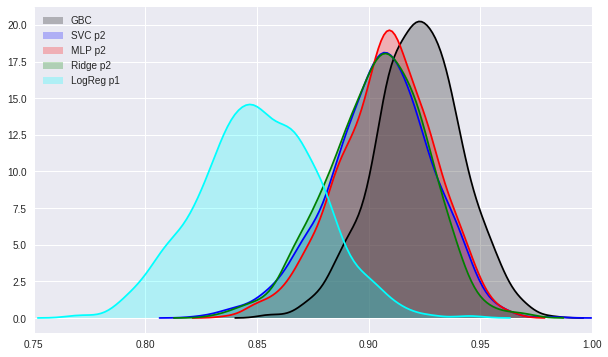

In [40]:
plt.figure(figsize=(10,6))
g = sns.kdeplot(scoresMCCV['GBC'],shade=True, color='black')
sns.kdeplot(scoresMCCV['SVC p2'],shade=True, color='blue')
sns.kdeplot(scoresMCCV['MLP p2'],shade=True, color='red')
sns.kdeplot(scoresMCCV['Ridge p2'],shade=True, color='green')
sns.kdeplot(scoresMCCV['LogReg p1'],shade=True, color='cyan')
g.set(xlim=(0.75,1))
g.legend(['GBC','SVC p2', 'MLP p2', 'Ridge p2', 'LogReg p1'], loc=2)

In [41]:
# Creating function to plot normal distribution

def gauss_dist(x, sigma, mu):
    shift = -0.5 * ((x - mu) / sigma)**2
    scale = sigma * np.sqrt(2 * np.pi)
    return np.exp(shift) / scale

/home/james/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


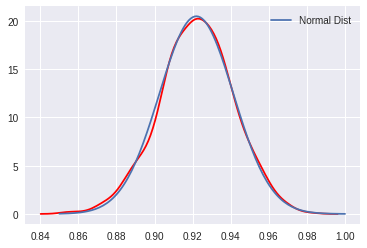

In [47]:
x_range = np.arange(0.85,1,0.001)
y_range = gauss_dist(x_range,scoresMCCV['GBC'].std(), scoresMCCV['GBC'].mean())
g = sns.kdeplot(scoresMCCV['GBC'], color='red')
plt.plot(x_range, y_range)
g.legend(['Normal Dist'])

/home/james/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


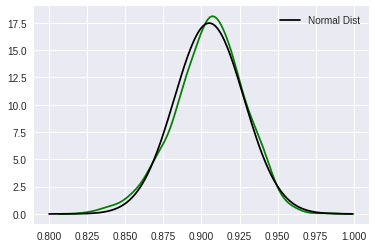

In [50]:
x_range = np.arange(0.80,1,0.001)
y_range = gauss_dist(x_range,scoresMCCV['SVC p2'].std(), scoresMCCV['SVC p2'].mean())
g = sns.kdeplot(scoresMCCV['SVC p2'], color='green')
plt.plot(x_range, y_range, color = 'k')
g.legend(['Normal Dist'])

SVC p2 average score : 90.51 %
SVC p2 standard deviation: 2.28 %
Best and Worst Scores:
Best SVC p2 score :  98.18 %. Obtained at Random State :  833
WorstSVC p2score :  82.42 %. Obtained at Random State :  530


GBC average score : 92.19 %
GBC standard deviation: 1.95 %
Best and Worst Scores:
Best GBC score :  98.18 %. Obtained at Random State :  500
WorstGBCscore :  85.45 %. Obtained at Random State :  608

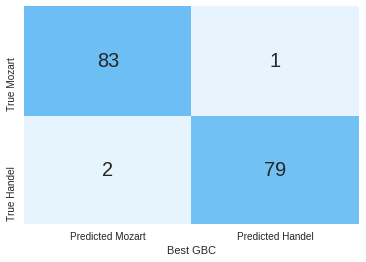

In [30]:
get_conf_matrix(500, gbc, 'Best GBC')

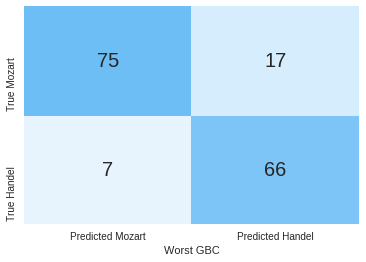

In [31]:
get_conf_matrix(608, gbc, 'Worst GBC')

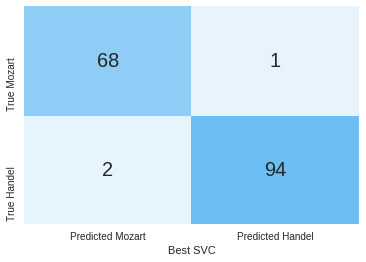

In [32]:
get_conf_matrix(833, svm_p2, 'Best SVC')

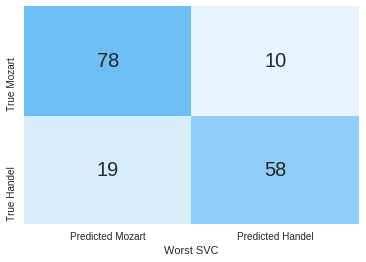

In [33]:
get_conf_matrix(530, svm_p2, 'Worst SVC')